In [31]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal


sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

##  Helper Functions from Previous Stuff

In [21]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [292]:
def calc_K(x,y=None,k=3,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

#  Start Simple with 1 hidden dimension

In [1403]:
n_neurons = 150 #q
hiddenDim = 12 #p
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
T_max = len(t)

tav = np.random.randint(1,3,size=hiddenDim)
sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(hiddenDim)]



C = np.array([5*np.arange(0,n_neurons),
              np.abs(45 - 5*np.arange(0,n_neurons,))])#
C = np.random.randint(-20,20,size=(n_neurons,hiddenDim))/2
d = np.random.randint(40,50,size=(n_neurons))



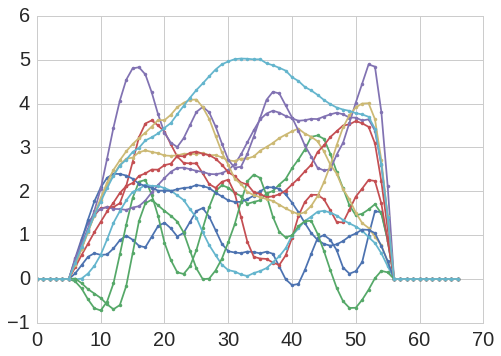

In [1404]:
x = np.zeros([hiddenDim,T_max])
params = [[np.random.randint(1,5),np.random.randint(1,5),np.random.randint(1,200)/200] for i in range(hiddenDim)]
#params = [[4,1,2e-1],
#          [1,2,1e0],
#          [6,3,5e-1]]

for i,p in enumerate(params):
    
    Ki = get_covariance_matrix(k=p[1],x=t,y=t,l=p[2])
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[p[0]]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(T_max-35),np.cos(np.linspace(0,.5*np.pi,num=5)),np.zeros(10)])

for i in range(hiddenDim):
    plt.plot(x[i],'.-')

In [1405]:
#this is the observed data, which we pretend are the spike trains
y = C.dot(x) + d[:,None] + np.random.normal(loc=0,scale=1,size=(n_neurons,T_max))

## C_big description

$
\begin{bmatrix}
    x_{cell1-hiddenstate1}       & x_{cell1-hiddenstate2} & ... x_{cell1-hiddenstatep} & 0 & 0 & 0 & 0 & \dots & 0 \\
    x_{cell2-hiddenstate1}       & x_{cell2-hiddenstate2} & ... x_{cell2-hiddenstatep} & 0 & 0 & 0 & 0 &\dots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & & \vdots \\
    x_{cellq-hiddenstate1}       & x_{cellq-hiddenstate2} & ... x_{cellq-hiddenstatep} & 0 & 0 & 0 & 0 &\dots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & & \vdots \\
    0 & 0 & \dots & x_{cell1-hiddenstate1}     & ... & x_{cell1-hiddenstatep}  & 0 & \dots & 0 \\
    0 & 0 & \dots & x_{cell2-hiddenstate1}     & ... & x_{cell2-hiddenstatep}  & 0 &\dots & 0 \\
    \vdots & \vdots &  & & \ddots & \ddots & \ddots & \ddots \\
    0 & 0 &  0 & 0 &  0 & \dots &  x_{cellq-hiddenstate1}     & \dots & x_{cellq-hiddenstatep}
\end{bmatrix}
$

In [1406]:
#K_big = np.kron(np.eye(T_max),Ki)

In [1407]:
#in C_big, the layout must be 
C_big = np.kron(C,np.eye(T_max))

In [1408]:
#### LETS make K-big

Kd = np.zeros([T_max,T_max,hiddenDim,hiddenDim])
print np.product(Kd.shape)
for t1 in range(T_max):
#    
    for t2 in range(T_max):
#        
        for xd in range(hiddenDim):
            Kd[t1,t2,xd,xd] = epsSignal*np.exp(-0.5*((t1-t2)**2/(.00020*params[xd][2])**2))

K_big = np.zeros([T_max*hiddenDim,T_max*hiddenDim])

for i in range(T_max):
    for j in range(T_max):
        K_big[i*hiddenDim:(i+1)*hiddenDim,j*hiddenDim:(j+1)*hiddenDim] = Kd[i,j]

646416


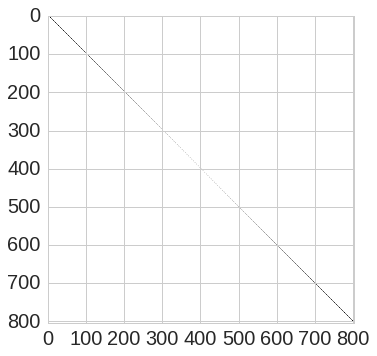

In [1409]:
plt.imshow(K_big)

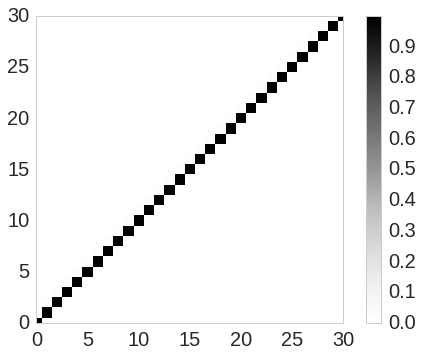

In [1398]:
plt.imshow(K_big,interpolation='None')
plt.xlim(0,30)
plt.ylim(0,30)
plt.colorbar()
plt.grid()

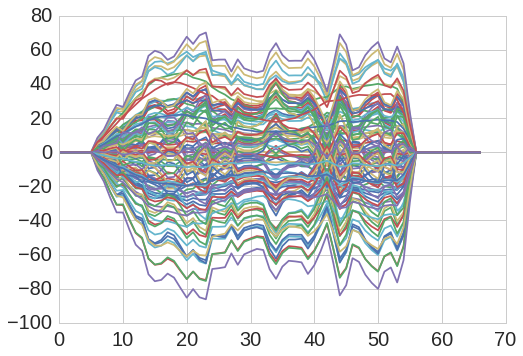

In [1399]:
for i in C_big.dot(x.flatten()).reshape(T_max,n_neurons,order='F').T:
    plt.plot(i)

In [1400]:
st = time.time()
n = K_big.dot(C_big.T).dot(np.linalg.inv(C_big.dot(K_big).dot(C_big.T) + 1e-3*np.eye(T_max*n_neurons))).dot(y.T.flatten(order='F') - np.tile(d,T_max))
print time.time() - st

3.84038996696


In [1401]:
C.shape

(100, 2)

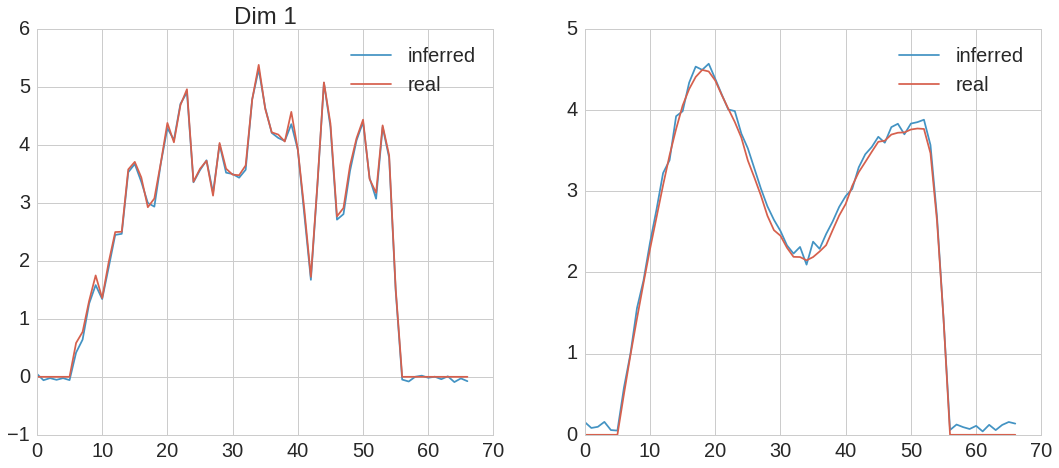

In [1402]:
newN = n.reshape(-1,67)
plt.figure(figsize=(18,16))
clrs = seaborn.color_palette('RdBu',n_colors=4)

nRows, nCols= [np.ceil(np.sqrt(hiddenDim)).astype('int')]*2
for i in range(hiddenDim):
    plt.title('Dim %s' %i)
    plt.subplot(nRows,nCols,i+1)
    plt.plot(newN[i],color=clrs[-1],label='inferred')
    plt.plot(x[i],color=clrs[0],label='real')

    plt.legend()

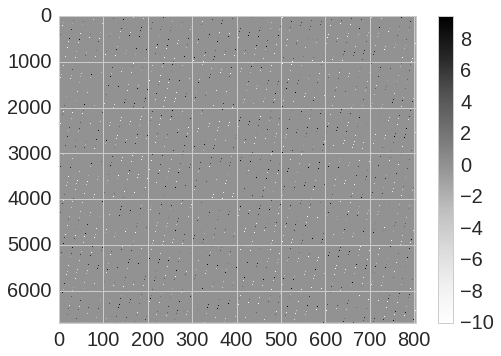

In [1304]:
plt.imshow(C_big,aspect='auto',interpolation='None')

plt.colorbar()


In [869]:
C_big[0]

array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

## GPFA Definitions 

In [1214]:
n_neurons = 200 #q
hiddenDim = 6  #p
n_timePoints = 67
t = np.linspace(-33,33,num=67)/10 #use this for an unmarked time series
T_max = len(t)

tav = np.random.randint(1,3,size=hiddenDim)
sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(hiddenDim)]



C = np.random.randint(-10,20,size=(n_neurons,hiddenDim))/4
d = np.random.randint(20,50,size=(n_neurons))



In [1215]:
Ki = get_covariance_matrix(k=3,x=t,y=t,l=5e-1)
Ki /= np.max(Ki)

In [1216]:
mvn1 = multivariate_normal(mean=[2]*n_timePoints,cov=Ki)
mvn2 = multivariate_normal(mean=[2]*n_timePoints,cov=Ki)

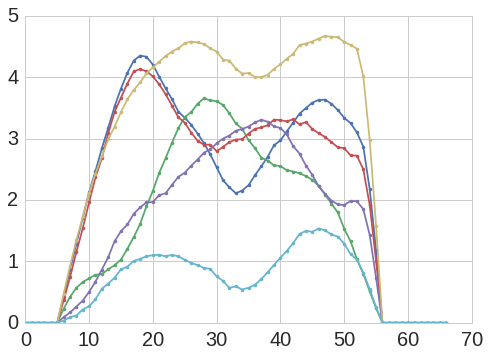

In [1217]:
x = np.zeros([hiddenDim,T_max])
params = [[np.random.randint(1,5),np.random.randint(1,5),np.random.randint(1,200)/200] for i in range(hiddenDim)]
#params = [[4,1,2e-1],
#          [1,2,1e0],
#          [6,3,5e-1]]

for i,p in enumerate(params):
    
    Ki = get_covariance_matrix(k=p[1],x=t,y=t,l=p[2])
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[p[0]]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(T_max-35),np.cos(np.linspace(0,.5*np.pi,num=5)),np.zeros(10)])

for i in range(hiddenDim):
    plt.plot(x[i],'.-')


In [1218]:
y = C.dot(x) + d[:,None] + np.random.normal(loc=0,scale=1,size=(n_neurons,T_max))

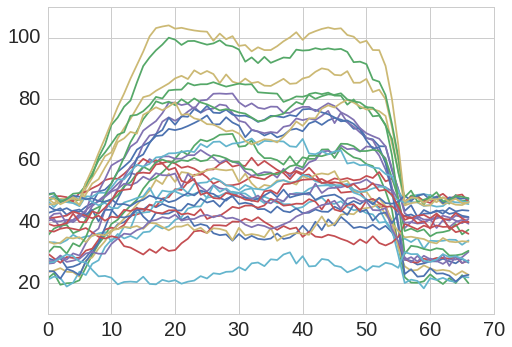

In [1219]:
for i in y[:30]:
    plt.plot(i)

## Lets Try Inferring this stuff

In [1220]:
C_big = np.kron(C,np.eye(T_max)).T
C_big.shape

(402, 13400)

In [ ]:
C

In [1221]:
epsNoise = 1e-3
epsSignal = 1 - epsNoise
binSize = .05
trialDur = 6

#T = range(0,int(trialDur/binSize))
len_T = len(t)
print len_T
K = np.zeros([hiddenDim, len(t), len(t)])
K_big = np.zeros([hiddenDim*len(t), hiddenDim*len(t)])

# Make small K (size TxT) for each xdim
for xd in range(hiddenDim):
    for i in t:
        for j in t:
            K[xd,i,j] = epsSignal*np.exp(-0.5*((i-j)**2/(params[xd][2])**2))
    K[xd] = K[xd] + epsNoise * np.eye(len(t))

# Make big K
for xd in range(hiddenDim):
    K_big[xd*len(t):(xd+1)*len(t),xd*len(t):(xd+1)*len(t)] = K[xd]


67


/home/yves/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


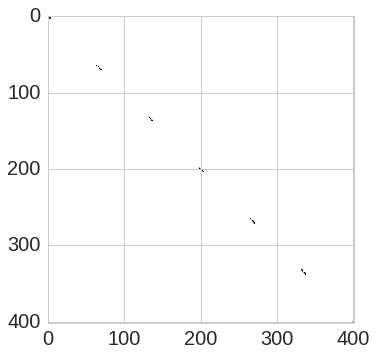

In [1222]:
plt.imshow(K_big,interpolation='None')

In [1223]:
st = time.time()
n = K_big.dot(C_big).dot(np.linalg.inv(C_big.T.dot(K_big).dot(C_big) + 1e-3*np.eye(T_max*n_neurons))).dot(y.flatten() - np.tile(d,T_max))
print time.time() - st

21.0624501705


In [1224]:
newN = n.reshape(-1,67)

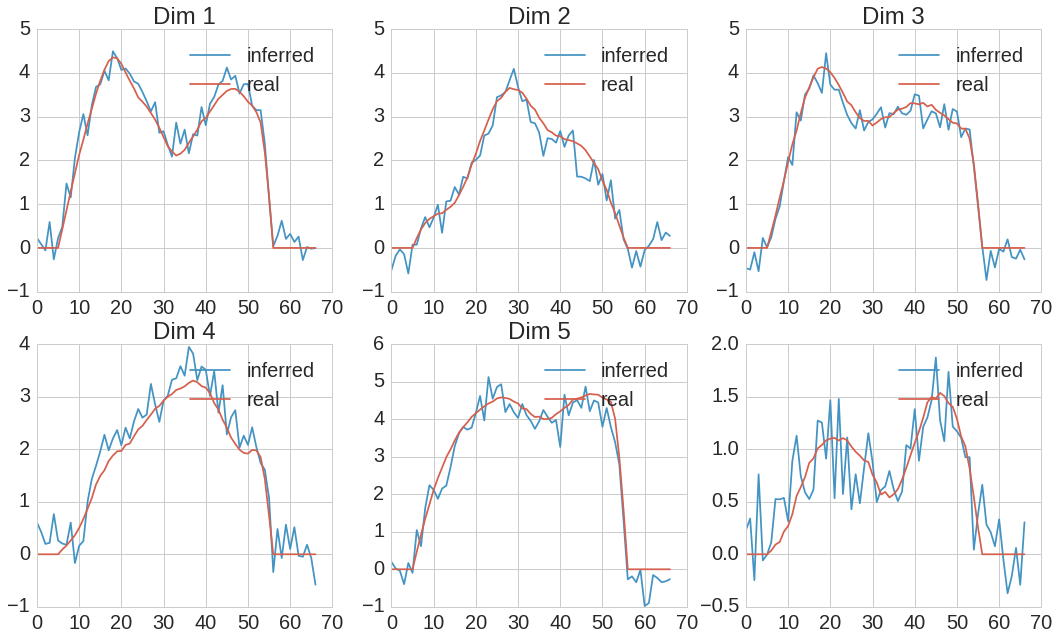

In [1225]:
newN = n.reshape(-1,67)
plt.figure(figsize=(18,16))
clrs = seaborn.color_palette('RdBu',n_colors=4)

nRows, nCols= [np.ceil(np.sqrt(hiddenDim)).astype('int')]*2
for i in range(hiddenDim):
    plt.title('Dim %s' %i)
    plt.subplot(nRows,nCols,i+1)
    plt.plot(newN[i],color=clrs[-1],label='inferred')
    plt.plot(x[i],color=clrs[0],label='real')

    plt.legend()

In [285]:
mvn2 = multivariate_normal(mean=taj,cov=Ki)

In [286]:
sampr = mvn2.rvs()
for i in range(50):
    sampr += mvn2.rvs()

In [287]:
sampr /= 50

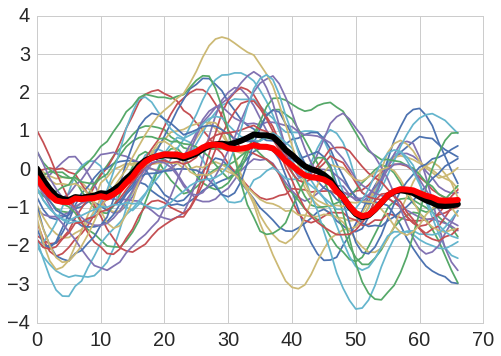

In [288]:
for i in range(30):
    plt.plot(mvn2.rvs())

plt.plot(sampr,linewidth=6,color='k')
plt.plot(traj,linewidth=6,color='r')

In [157]:
K = np.zeros([len(t)*hiddenDim,len(t)*hiddenDim])

k = 1
l = 1e0
for t1 in t:
    for t2 in t:
        for dim in range(hiddenDim):
            K[dim*hiddenDim:(dim+1)*hiddenDim,dim*hiddenDim:(dim+1)*hiddenDim] = kernel(t1,t2)

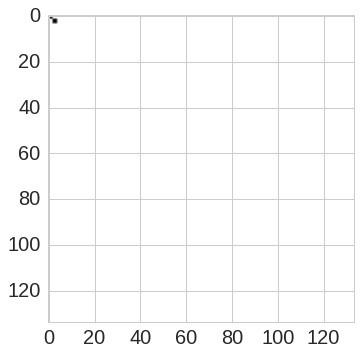

In [ ]:
def makeK_big(params, trialDur, binSize, epsNoise = 0.001):
    [ydim,xdim] = np.shape(params['C'])
    epsSignal = 1 - epsNoise
    params['tau'] = np.ndarray.flatten(params['tau'])

    T = range(0,int(trialDur/binSize))
    K = np.zeros([xdim, len(T), len(T)])
    K_big = np.zeros([xdim*len(T), xdim*len(T)])
    
    # Make small K (size TxT) for each xdim
    for xd in range(xdim):
        for i in T:
            for j in T:
                K[xd,i,j] = epsSignal*np.exp(-0.5*((T[i]*binSize-T[j]*binSize)**2/(params['tau'][xd]*1000)**2))
        K[xd] = K[xd] + epsNoise * np.eye(len(T))

    # Make big K
    for xd in range(xdim):
        K_big[xd*len(T):(xd+1)*len(T),xd*len(T):(xd+1)*len(T)] = K[xd]
    
    return K_big, K

In [172]:
[ydim,xdim] = [50,2]
epsNoise = 1e-3
epsSignal = 1 - epsNoise
params = {}
params['tau'] = [1e-3]*xdim
binSize = .05
trialDur = 4

T = range(0,int(trialDur/binSize))
len_T = len(T)
print len_T
K = np.zeros([xdim, len(T), len(T)])
K_big = np.zeros([xdim*len(T), xdim*len(T)])

# Make small K (size TxT) for each xdim
for xd in range(xdim):
    for i in T:
        for j in T:
            K[xd,i,j] = epsSignal*np.exp(-0.5*((T[i]*binSize-T[j]*binSize)**2/(params['tau'][xd]*1000)**2))
    K[xd] = K[xd] + epsNoise * np.eye(len(T))

# Make big K
for xd in range(xdim):
    K_big[xd*len(T):(xd+1)*len(T),xd*len(T):(xd+1)*len(T)] = K[xd]


80


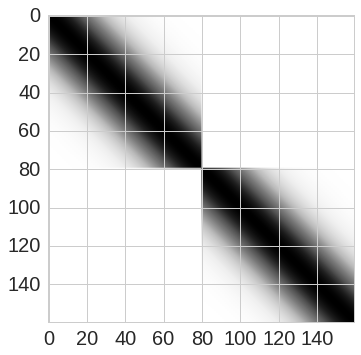

In [173]:
plt.imshow(K_big)

50

##  Code from Macke Lab Hooram Nam (sp?)

In [ ]:
import numpy as np
import scipy.optimize as op

In [ ]:
# Laplace Inference -----------------------------------------------------------
def negLogPosteriorUnNorm(xbar, ybar, C_big, d_big, K_bigInv, xdim, ydim):
    xbar = np.ndarray.flatten(np.asarray(xbar))
    ybar = np.ndarray.flatten(np.asarray(ybar))
    T = int(len(d_big)/ydim)

    C_big = np.asarray(C_big)
    d_big = np.asarray(d_big)

    K_bigInv = np.asarray(K_bigInv)

    A = np.dot(C_big.T, xbar) + d_big
    Aexp = np.exp(A)

    L1 = np.dot(Aexp, np.ones(ydim*T))
    L2 = - np.dot(ybar, A.T)
    L3 = 0.5*np.dot(xbar,np.dot(K_bigInv,xbar))

    L = L1 + L2 + L3

    # pdb.set_trace()
    return L

def negLogPosteriorUnNorm_grad(xbar, ybar, C_big, d_big, K_bigInv, xdim, ydim):
    xbar = np.asarray(xbar)
    ybar = np.asarray(ybar)

    A = np.dot(C_big.T, xbar) + d_big
    A = np.float64(A)
    Aexp = np.exp(A)

    dL1 = np.dot(Aexp,C_big.T)
    dL2 = - np.dot(ybar, C_big.T)
    dL3 = np.dot(xbar, K_bigInv)

    dL = dL1 + dL2 + dL3

    return dL

def negLogPosteriorUnNorm_hess(xbar, ybar, C_big, d_big, K_bigInv, xdim, ydim):
    xbar = np.asarray(xbar)
    ybar = np.asarray(ybar)

    T = int(len(xbar)/xdim)

    A = np.dot(C_big.T, xbar) + d_big
    A = np.float64(A)

    Aexp = np.exp(A)
    Aexpdiagonal = sp.sparse.spdiags(Aexp,0,ydim*T,ydim*T)
    temp = Aexpdiagonal.dot(C_big.T)

    ddL = np.dot(C_big, temp) + K_bigInv

    return ddL



In [ ]:
def laplace(experiment,
            params,
            prevOptimRes = None,
            returnOptimRes = True,
            verbose = False,
            optimMethod = 'Newton-CG'):
    '''
    laplaceInfRes, -post_lik = laplace(experiment, params)
    '''
    ridge = 0
    
    #here T is the number of bins ydim is the number of neurons
    [ydim,T] = np.shape(experiment.data[0]['Y'])
    [ydim, xdim] = np.shape(params['C'])     #xdim is the number of latent dimensions
    numTrials = len(experiment.data)  # number of trials
    trialDur = experiment.trialDur 
    binSize = experiment.binSize      # size of bins

    # make big parameters
    C_big, d_big = util.makeCd_big(params,T)
    K_big, K = util.makeK_big(params, trialDur, binSize)
    K_bigInv = np.linalg.inv(K_big)
    
    x_post_mean = []
    x_post_cov = []
    x_vsmGP = []
    x_vsm = []

    post_lik = 0
    
    # store current optimization result to use as initialization for inference in next EM iteration
    lapOptimRes = []

    for trial in range(numTrials):
        if verbose: print('laplace inference trajectory of trial ' +str(trial+1) +'...')
        y = experiment.data[trial]['Y']
        ybar = np.ndarray.flatten(np.reshape(y, ydim*T))

        if prevOptimRes == None:
            xInit = np.ndarray.flatten(np.zeros([xdim*T,1]))
        else:
            xInit = prevOptimRes[trial]


            
        ####
        resLap = op.minimize(
            fun = negLogPosteriorUnNorm,
            x0 = xInit,
            method=optimMethod,
            args = (ybar, C_big, d_big, K_bigInv, xdim, ydim),
            jac = negLogPosteriorUnNorm_grad,
            hess = negLogPosteriorUnNorm_hess,
            options = {'disp': False,'maxiter': 10000})
        lapOptimRes.append(resLap.x)
        post_lik = post_lik + resLap.fun
        x_post_mean.append(np.reshape(resLap.x,[xdim,T]))
        hess = negLogPosteriorUnNorm_hess(resLap.x, ybar, C_big, d_big, K_bigInv, xdim, ydim)
        PostCovGP = np.linalg.inv(hess)
        
        PostCovGP = PostCovGP + ridge*np.diag(np.ones(xdim*T))
        x_post_cov.append(PostCovGP)

        temp_vsmGP = np.zeros([T,T,xdim])
        for kk in range(xdim):
            temp_vsmGP[:,:,kk] = PostCovGP[kk*T:(kk+1)*T, kk*T:(kk+1)*T]
        x_vsmGP.append(temp_vsmGP)

        temp_vsm = np.zeros([T,xdim,xdim])
        for kk in range(T):
            temp_vsm[kk][:,:] = PostCovGP[kk::T,kk::T]
        x_vsm.append(temp_vsm)
        # pdb.set_trace()

    post_lik = post_lik / numTrials
    laplaceInfRes = {
        'post_mean': x_post_mean,
        'post_cov' : x_post_cov,
        'post_vsm': x_vsm,
        'post_vsmGP': x_vsmGP}

    if returnOptimRes == True:
        return laplaceInfRes, -post_lik, lapOptimRes
    else:
        return laplaceInfRes, -post_lik


In [ ]:
def makeCd_big(params, T):
    #Here T is the number of bins in the trial
    C_big = np.kron(params['C'],np.eye(T)).T
    d_big = np.kron(np.ndarray.flatten(params['d']),np.ones(T)).T
return C_big, d_big

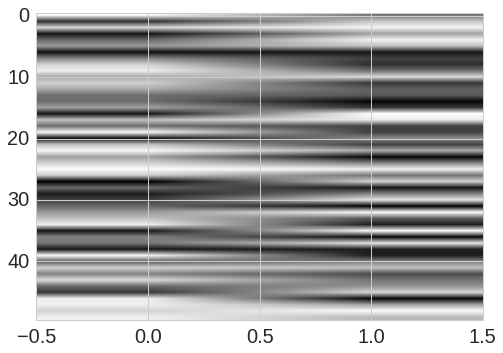

In [170]:
plt.imshow(C,aspect='auto')

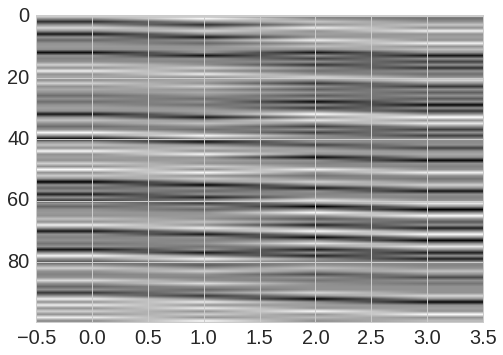

In [171]:
C_big = np.kron(C,np.eye(2))
plt.imshow(C_big,aspect='auto')

In [7]:
def makeK_big(params, trialDur, binSize, epsNoise = 0.001):
    [ydim,xdim] = np.shape(params['C'])
    epsSignal = 1 - epsNoise
    params['tau'] = np.ndarray.flatten(params['tau'])

    T = range(0,int(trialDur/binSize))
    K = np.zeros([xdim, len(T), len(T)])
    K_big = np.zeros([xdim*len(T), xdim*len(T)])
    
    # Make small K (size TxT) for each xdim
    for xd in range(xdim):
        for i in T:
            for j in T:
                K[xd,i,j] = epsSignal*np.exp(-0.5*((T[i]*binSize-T[j]*binSize)**2/(params['tau'][xd]*1000)**2))
        K[xd] = K[xd] + epsNoise * np.eye(len(T))

    # Make big K
    for xd in range(xdim):
        K_big[xd*len(T):(xd+1)*len(T),xd*len(T):(xd+1)*len(T)] = K[xd]
    
    return K_big, K

In [ ]:
    """Parameters:
    ===========
      * xdim       : int, latent dimensionality to fit
      * ydim       : int, number of neurons in the dataset
      * experiment : (optional) If a third optional argument of util.dataset object is given, 
                     the fucntion returns a dictionary of parameters obtained by performing Poisson-
                     PCA Leave this argument empty to initialize randomly.
    Returns:
    ========
         A dictionary of model parameters.
    """
if experiment == None:
    print('Initializing parameters randomly..')
    params = {
        'C': np.random.rand(ydim,xdim)*2 - 1,
        'd': np.random.randn(ydim)*2 - 2,
        'tau': np.random.rand(xdim)*0.5} # seconds